# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-09-25 05:26:31,524 INFO    : root         : Using LISA logging configuration:
2020-09-25 05:26:31,525 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-09-25 05:26:31,784 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-09-25 05:26:31,798 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 0EBF5TC3_QOS_200304_200304_135427_note.html - 147374 lines are Ok
Parsing 0EBF5TC3_QOS_200304_200304_145400_note.html - 170700 lines are Ok
Parsing 0EBF5TC3_QOS_200304_200304_105453_note.html - 154901 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_181416_note.html - 135054 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_192028_note.html - 121365 lines are Ok
Parsing 0FBF5TA2_QOS_200117_200117_202640_note.html - 132864 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3074.0,NaN,NaN,NaN,NaN,NaN,NaN,3.682,NaN
1545.0,NaN,133.664,70.112,144.500,212.288,11.693,43.880,NaN
3114.0,7.087,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1579.0,NaN,42.084,23.459,NaN,NaN,NaN,NaN,NaN
1260.0,NaN,10.994,2.009,NaN,NaN,NaN,0.529,NaN
2061.0,NaN,2.695,4.465,NaN,NaN,NaN,NaN,NaN
1261.0,NaN,1.167,1.313,NaN,NaN,NaN,NaN,NaN
2124.0,0.301,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,597.346


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
2049.0,NaN,3.675,1.314,NaN,NaN,NaN,NaN,NaN
1546.0,NaN,132.485,1.014,321.989,165.934,13.090,24.966,NaN
12971.0,NaN,NaN,NaN,314.595,NaN,47.564,NaN,NaN
1580.0,NaN,38.828,27.520,NaN,NaN,NaN,NaN,NaN
2093.0,0.264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1262.0,NaN,0.927,47.128,NaN,NaN,NaN,NaN,NaN
1263.0,NaN,1.488,0.758,NaN,NaN,NaN,NaN,NaN
12913.0,29.624,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3090.0,9.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1266.0,NaN,1.306,1.178,NaN,NaN,NaN,NaN,NaN
2124.0,0.441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066.0,NaN,2.609,1.944,NaN,NaN,NaN,NaN,NaN
1551.0,NaN,151.985,1.174,115.774,177.538,13.937,28.133,NaN
1265.0,NaN,3.841,49.490,NaN,NaN,NaN,NaN,NaN
1234.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,499.984
1593.0,NaN,36.329,23.403,NaN,NaN,NaN,NaN,NaN
3162.0,20.232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12815.0,41.049,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5408.0,NaN,32.029,31.230,NaN,NaN,NaN,NaN,NaN
17218.0,NaN,NaN,NaN,277.819,NaN,10.391,NaN,NaN
5029.0,NaN,1.125,24.730,NaN,NaN,NaN,NaN,NaN
5030.0,NaN,2.827,0.974,NaN,NaN,NaN,NaN,NaN
5617.0,NaN,NaN,NaN,NaN,NaN,NaN,0.050,NaN
4970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549.664
5814.0,0.271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6961.0,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17109.0,NaN,155.373,2.243,129.309,183.535,12.793,41.873,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5410.0,NaN,24.500,27.480,NaN,NaN,NaN,NaN,NaN
5034.0,NaN,1.626,19.826,NaN,NaN,NaN,NaN,NaN
5035.0,NaN,1.663,1.522,NaN,NaN,NaN,NaN,NaN
5741.0,NaN,2.453,1.252,NaN,NaN,NaN,NaN,NaN
16622.0,NaN,165.885,2.909,110.326,171.426,10.951,32.084,NaN
7053.0,16.208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16658.0,26.697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.731
16729.0,NaN,NaN,NaN,271.720,NaN,10.325,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5764.0,NaN,3.284,1.739,NaN,NaN,NaN,NaN,NaN
16581.0,NaN,155.983,1.966,128.352,190.346,10.894,34.494,NaN
5414.0,NaN,31.955,35.605,NaN,NaN,NaN,NaN,NaN
7015.0,14.943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16618.0,23.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,547.506
5037.0,NaN,1.393,20.821,NaN,NaN,NaN,NaN,NaN
5038.0,NaN,5.355,1.598,NaN,NaN,NaN,NaN,NaN
16689.0,NaN,NaN,NaN,267.956,NaN,10.042,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time
No launching time


In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                             pid               
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note 1233.0  597.346000
                                             1235.0  661.023000
                                             1234.0  499.984000
                                             mean    586.117667
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note 4970.0  549.664000
                                             4979.0  525.731000
                                             4972.0  547.506000
                                             mean    540.967000

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note time                                0   
                                             RUNNING                             0   
                                             RUNNABLE                            0   
                                             SLEEPING                            0   
                                             UNINTERUPTIBLE_SLEEP                0   
                                             UNINTERUPTIBLE_SLEEP(I/O)           0   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note time                                0   
                                             RUNNING                             0   
                                             RUNNABLE                            0   
                                             SLEEPING                            0   
                                             UNINTERUPTIBLE_SLEEP                0   
                                             UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                         time                                0   
                                             RUNNING                             0   
                                             RUNNABLE                            0   
                                             SLEEPING                            0   
                                             UNINTERUPTIBLE_SLEEP                0   
                                             UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                        Choreographer #0  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note time                                139.378   
                                             RUNNING                              27.941   
                                             RUNNABLE                              2.467   
                                             SLEEPING                             91.850   
                                             UNINTERUPTIBLE_SLEEP                  0.000   
                                             UNINTERUPTIBLE_SLEEP(I/O)            17.120   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note time                                159.080   
                                             RUNNING                              80.632   
                                             RUNNABLE                              0.893   
                                             SLEEPING                             59.978   
                                             UNINTERUPTIBLE_SLEEP                  0.212   
                                             UNINTERUPTIBLE_SLEEP(I/O)            17.365   
DIFF                                         time                                -19.702   
                                             RUNNING                             -52.691   
                                             RUNNABLE                              1.574   
                                             SLEEPING                             31.872   
                                             UNINTERUPTIBLE_SLEEP                 -0.212   
                                             UNINTERUPTIBLE_SLEEP(I/O)            -0.245   

                                                                        Choreographer #1  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note time                                 24.100   
                                             RUNNING                              17.414   
                                             RUNNABLE                              0.908   
                                             SLEEPING                              1.563   
                                             UNINTERUPTIBLE_SLEEP                  0.000   
                                             UNINTERUPTIBLE_SLEEP(I/O)             4.215   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note,time,0,139.378,24.100,194.088,185.253,12.907,32.326,0
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note,time,0,159.080,2.373,122.662,181.769,11.546,36.150,0
DIFF,time,0,-19.702,21.727,71.426,3.484,1.361,-3.824,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note,26.359,29.624,41.049,32.344000
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note,31.045,26.697,23.184,26.975333


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0xec/0x848,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
uninter_reason//SyS_mprotect+0x88/0x208,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
uninter_reason//SyS_prctl+0x540/0xcc0,0.000000,0.000000,0.333333,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0x118/0x13c,0.000000,0.000000,0.666667,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0xf0/0x108,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
uninter_reason//_synchronize_rcu_expedited+0x260/0x384,0.000000,0.000000,0.000000,0.000000,0.0,0.666667
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0x2a8/0x424,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
uninter_reason//unlink_file_vma+0x2c/0xa8,0.000000,0.000000,0.000000,1.666667,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0x104,0.000000,0.000000,1.000000,0.000000,0.0,0.000000


In [25]:
print(group2.title)
display(df2)

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0xec/0x848,0.000000,0.0,1.000000,0.000000,0.0,0.000000
uninter_reason//SyS_mprotect+0x88/0x208,0.666667,0.0,0.666667,0.000000,0.0,0.000000
uninter_reason//SyS_prctl+0x540/0xcc0,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0x118/0x13c,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0xf0/0x108,0.000000,0.0,1.333333,0.000000,0.0,0.000000
uninter_reason//_synchronize_rcu_expedited+0x260/0x384,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.0,0.000000,0.000000,0.0,0.333333
uninter_reason//do_page_fault+0x2a8/0x424,6.000000,0.0,7.333333,4.333333,1.0,1.333333
uninter_reason//unlink_file_vma+0x2c/0xa8,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0x104,0.000000,0.0,1.000000,0.333333,0.0,0.000000


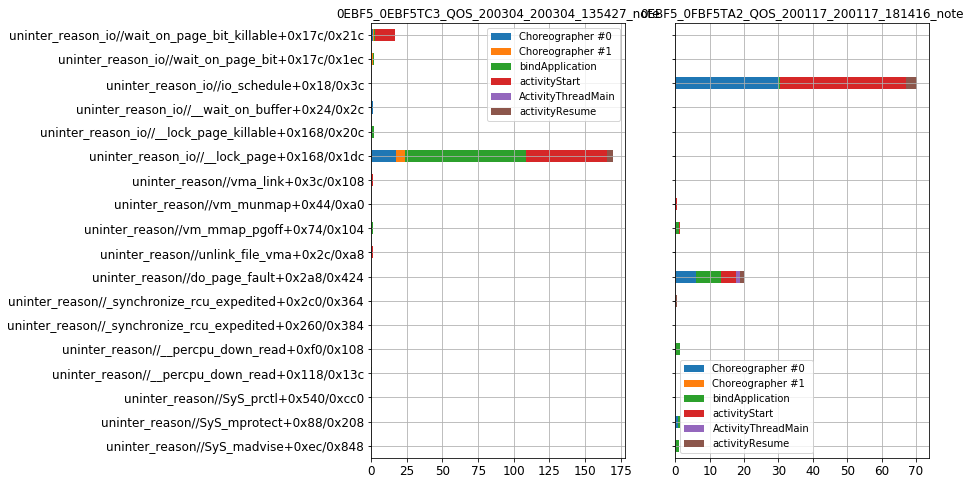

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

The number of count in each reason of uninterruptible sleep.

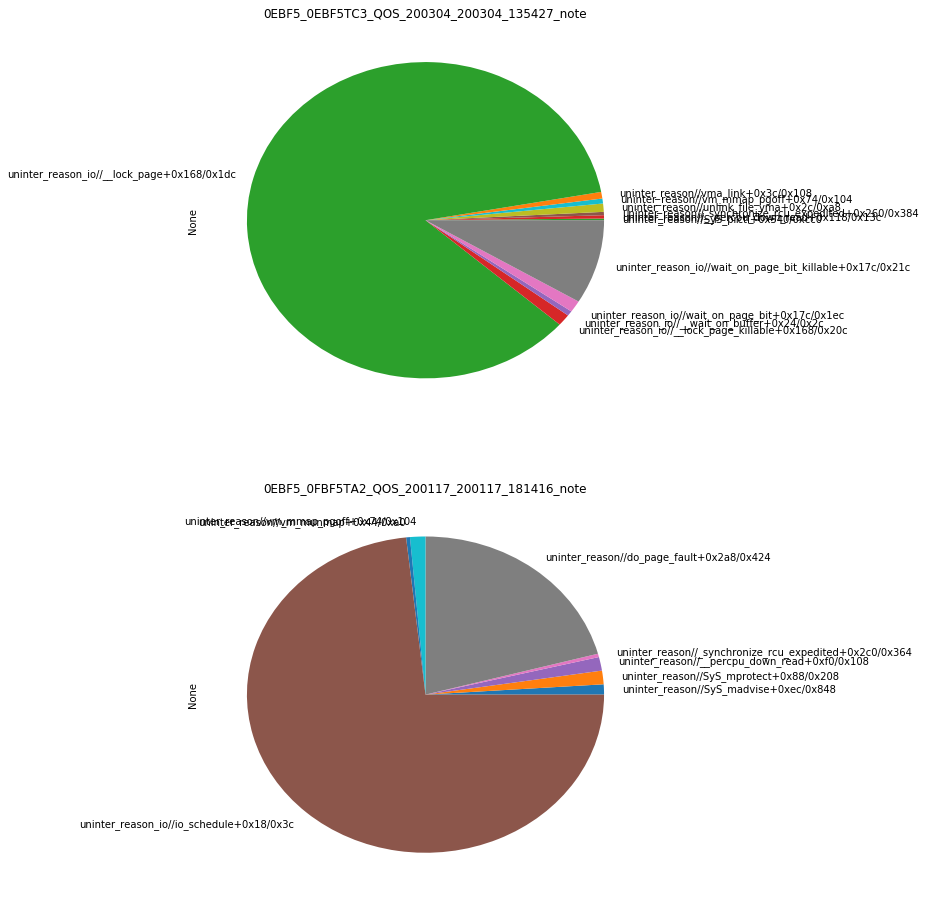

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note core0                 8   
                                             core1                 1   
                                             core2                 1   
                                             core3                 2   
                                             core4                 0   
                                             core5                 0   
                                             core6                59   
                                             core7                45   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note core0                 0   
                                             core1                 1   
                                             core2                 1   
                                             core3                 2   
                                             core4                66   
                                             core5                22   
                                             core6                29   
                                             core7                34   

                                                    Choreographer #1  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note core0                 0   
                                             core1                 0   
                                             core2                 0   
                                             core3                 0   
                                             core4                 0   
                                             core5                 0   
                                             core6                22   
                                             core7                22   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note core0                 0   
                                             core1                 0   
                                             core2                 0   
                                             core3                 0   
                                             core4                 0   
                                             core5                 0   
                                             core6                 1   
                                             core7                 2   

                                                    bindApplication  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note core0                5   
                                             core1                7   
                                             core2               16   
                                             core3                6   
                                             core4               14   
                                             core5                4   
                                             core6              215   
                                             core7              189   
0EBF5_0FBF5TA2_QOS_200117_200117_181416_note core0                9   
                                             core1                6   
                                             core2                1   
                                             core3                2   
                                             core4               41   
                                             core5               64   
                                             core6               30   
                                             core7                7   

                                                    activityStart  \
0EBF5_0EBF5TC3_QOS_200304_200304_135427_note core0              0   
                                             core1              0   
                                             core2              2   
                                             core3              2   
                                             core

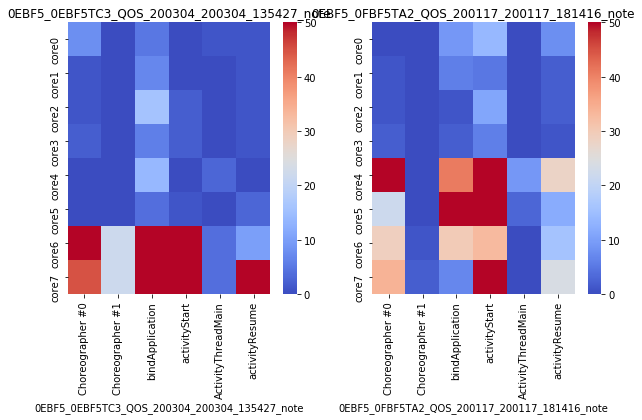

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,0,1,0,NaN
core1,NaN,0,0,0,0,0,1,NaN
core2,NaN,1,0,6,2,0,0,NaN
core3,NaN,0,0,5,0,0,0,NaN
core4,NaN,0,0,11,0,1,0,NaN
core5,NaN,0,0,0,0,0,3,NaN
core6,NaN,26,22,48,48,0,3,NaN
core7,NaN,18,18,9,116,2,25,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,5,0,2,0,0,0,NaN
core1,NaN,0,0,6,0,0,0,NaN
core2,NaN,0,0,8,0,0,0,NaN
core3,NaN,0,0,1,0,0,0,NaN
core4,NaN,0,0,1,0,0,0,NaN
core5,NaN,0,0,0,0,0,0,NaN
core6,NaN,12,0,137,68,4,6,NaN
core7,NaN,17,3,171,49,1,20,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,3,0,1,0,0,1,NaN
core1,NaN,1,0,1,0,0,0,NaN
core2,NaN,0,0,2,0,0,1,NaN
core3,NaN,2,0,0,2,0,1,NaN
core4,NaN,0,0,2,0,2,0,NaN
core5,NaN,0,0,4,1,0,0,NaN
core6,NaN,21,0,30,49,0,1,NaN
core7,NaN,10,1,9,75,1,16,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,6,0,3,NaN
core1,NaN,0,0,5,0,0,0,NaN
core2,NaN,0,0,1,3,0,1,NaN
core3,NaN,2,0,1,2,0,1,NaN
core4,NaN,26,0,13,13,4,10,NaN
core5,NaN,12,0,28,19,2,4,NaN
core6,NaN,4,1,1,14,0,3,NaN
core7,NaN,11,0,4,37,0,12,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,4,5,0,2,NaN
core1,NaN,0,0,0,1,0,1,NaN
core2,NaN,0,0,0,4,0,0,NaN
core3,NaN,0,0,0,2,0,0,NaN
core4,NaN,25,0,13,31,3,14,NaN
core5,NaN,3,0,25,25,0,7,NaN
core6,NaN,13,0,8,6,0,0,NaN
core7,NaN,9,1,0,29,0,7,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,3,3,0,3,NaN
core1,NaN,1,0,1,4,0,1,NaN
core2,NaN,1,0,0,4,0,1,NaN
core3,NaN,0,0,1,2,0,0,NaN
core4,NaN,15,0,15,15,2,4,NaN
core5,NaN,7,0,11,26,1,1,NaN
core6,NaN,12,0,21,13,0,13,NaN
core7,NaN,14,1,3,28,0,5,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  R  I  V  I  R  I         4  318.352521
                   1    I  I  I  I  V  I  I  I         4  318.353848
                   2    R  R  R  R  I  V  I  R         5  318.364282
bindApplication    0    R  R  R  R  I  I  V  I         6  318.366278
                   1    R  I  I  R  I  I  V  I         6  318.366588
                   2    I  R  V  R  I  I  I  I         2  318.367896
                   3    R  R  R  R  I  I  V  I         6  318.368103
                   4    I  R  I  R  I  I  V  I         6  318.368485
                   5    R  I  I  I  I  I  V  I         6  318.372241
                   6    I  I  I  I  I  I  V  R         6  318.373259
                   7    I  I  I  R  I  I  V  R         6  318.373627
                   8    I  I  I  I  I  I  V  I         6  318.375083
                   9    I  R  I  I  I  R  V  I         6  318.380101
                   10   I  R  I  I  I  I  V  R         6  318.380629
                   11   R  I  I  I  I  I  V  R         6  318.380709
                   12   I  I  I  I  I  I  V  R         6  318.380805
                   13   I  I  I  I  I  I  V  R         6  318.380850
                   14   I  I  V  I  I  I  R  I         2  318.400183
                   15   I  I  I  I  R  I  V  I         6  318.406051
                   16   I  I  I  I  I  I  V  I         6  318.408516
                   17   I  I  I  I  I  I  V  I         6  318.408828
                   18   I  I  I  I  I  I  V  I         6  318.409076
                   19   R  I  I  I  R  I  V  I         6  318.409422
                   20   I  I  I  I  R  I  V  I         6  318.409920
                   21   I  I  R  I  R  I  V  I         6  318.414185
                   22   I  I  R  I  I  I  V  I         6  318.414883
                   23   I  R  R  I  I  R  V  I         6  318.416966
                   24   I  R  R  I  I  R  V  R         6  318.417947
                   25   I  R  R  I  R  R  V  R         6  318.419269
                   26   R  R  R  I  R  R  R  V         7  318.420226
                   27   R  I  R  I  R  R  V  R         6  318.420848
                   28   V  R  R  I  R  I  R  I         0  318.421724
                   29   I  R  R  R  I  V  I  I         5  318.423093
                   30   R  R  I  R  I  I  V  I         6  318.423401
                   31   I  R  I  R  R  R  V  I         6  318.423803
                   32   I  R  R  I  I  I  V  I         6  318.426178
                   33   I  R  R  R  I  I  V  I         6  318.426594
                   34   I  I  I  I  I  R  I  V         7  318.429296
                   35   I  V  I  I  R  R  R  I         1  318.430813
                   36   R  R  I  I  I  I  I  V         7  318.436294
                   37   R  R  R  I  R  I  I  V         7  318.436673
                   38   I  R  I  I  I  I  I  V         7  318.439627
                   39   I  I  I  R  V  I  I  I         4  318.445391
                   40   I  I  I  R  V  I  R  I         4  318.447767
                   41   I  I  I  R  R  I  R  V         7  318.452107
                   42   I  I  I  I  I  I  I  V         7  318.454108
                   43   I  I  I  I  R  V  I  I         5  318.454510
                   44   R  I  R  R  I  V  R  I         5  318.460902
                   45   R  I  I  I  R  R  V  I         6  318.467219
                   46   I  R  I  I  R  R  I  V         7  318.474210
                   47   R  R  I  I  I  R  I  V         7  318.474490
                   48   R  I  I  I  I  R  R  V         7  318.480837
activityStart      0    R  I  I  I  I  I  R  V         7  318.481749
                   1    I  R  I  R  R  R  I  V         7  318.483483
                   2    I  I  I  I  I  I  V  I         6  318.486556
                   3    I  R  I  I  R  I  V  R         6  318.487844
                   4    I  I  R  I  I  I  V  I         6  318.488602
                   5  

In [35]:
print(group2.title)
display(GetCoreStats(group2))

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0   I  I  R  I  V  I  I  I         4  324.945089
                   1   I  I  R  I  R  V  R  I         5  324.946560
                   2   I  I  I  R  R  R  V  R         6  324.954034
bindApplication    0   I  I  I  R  V  R  I  I         4  324.956524
                   1   I  I  I  R  R  I  V  I         6  324.957620
                   2   I  I  I  R  R  I  V  I         6  324.957663
                   3   I  I  I  R  I  I  V  I         6  324.958180
                   4   I  I  I  R  I  R  V  I         6  324.958215
                   5   I  I  I  R  V  I  I  I         4  324.958363
                   6   I  I  I  R  V  R  R  I         4  324.958397
                   7   I  I  I  R  R  R  V  I         6  324.958991
                   8   I  I  I  R  R  R  V  I         6  324.959308
                   9   I  I  I  R  R  R  V  I         6  324.960118
                   10  I  I  I  R  I  V  R  I         5  324.960400
                   11  I  I  I  R  R  V  R  I         5  324.965383
                   12  I  I  I  R  R  V  I  I         5  324.966257
                   13  I  I  I  I  I  V  I  I         5  324.967907
                   14  I  I  I  I  R  V  R  I         5  324.968555
                   15  I  I  I  I  R  V  I  I         5  324.972054
                   16  I  I  I  I  R  V  I  I         5  324.973269
                   17  I  R  I  I  R  V  I  R         5  324.990974
                   18  R  V  I  R  R  R  I  I         1  324.994731
                   19  V  I  I  R  R  R  I  I         0  324.995305
                   20  V  I  I  R  R  R  I  R         0  324.995974
                   21  R  I  I  I  V  I  I  R         4  324.996651
                   22  R  I  I  I  V  R  I  I         4  324.997583
                   23  I  R  I  I  V  I  I  I         4  325.003977
                   24  R  R  I  I  V  R  R  I         4  325.005116
                   25  I  I  I  I  V  R  I  I         4  325.009883
                   26  R  R  I  I  V  I  R  I         4  325.011758
                   27  R  R  I  I  V  I  R  I         4  325.014057
                   28  R  R  I  I  V  I  I  I         4  325.014380
                   29  I  I  I  R  V  I  R  I         4  325.016987
                   30  I  R  I  R  I  V  I  I         5  325.023238
                   31  R  R  I  V  I  R  R  I         3  325.024866
                   32  R  R  I  I  I  V  R  I         5  325.025171
                   33  I  R  I  I  I  R  V  I         6  325.028073
                   34  I  R  I  R  I  R  V  I         6  325.028123
                   35  I  I  I  I  I  R  V  I         6  325.029391
                   36  R  I  I  I  I  R  V  I         6  325.029875
                   37  I  I  I  I  I  R  V  I         6  325.030720
                   38  V  I  I  I  I  R  R  I         0  325.034022
                   39  I  I  I  I  I  R  V  I         6  325.034706
                   40  R  R  I  I  I  R  V  I         6  325.036465
                   41  R  I  I  I  I  R  V  I         6  325.036652
                   42  I  I  I  I  I  R  V  I         6  325.036895
                   43  R  I  I  R  V  I  R  I         4  325.037397
                   44  R  I  I  I  I  R  V  I         6  325.038314
                   45  R  R  I  I  I  I  V  I         6  325.043111
                   46  R  R  I  I  I  I  V  R         6  325.043572
                   47  I  I  R  I  I  I  V  R         6  325.045100
                   48  R  R  I  I  R  R  V  R         6  325.053747
                   49  R  R  I  I  R  V  R  I         5  325.055672
                   50  I  R  R  R  I  R  R  V         7  325.062468
                   51  R  I  I  I  R  I  R  V         7  325.071513
                   52  R  R  I  R  V  R  R  I         4  325.076909
                   53  I  R  I  R  I  I  R  V         7  325.077533
                   54  I  I  I  I  R  R  R  V         7  325.084660
activitySta

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

0EBF5_0EBF5TC3_QOS_200304_200304_135427_note


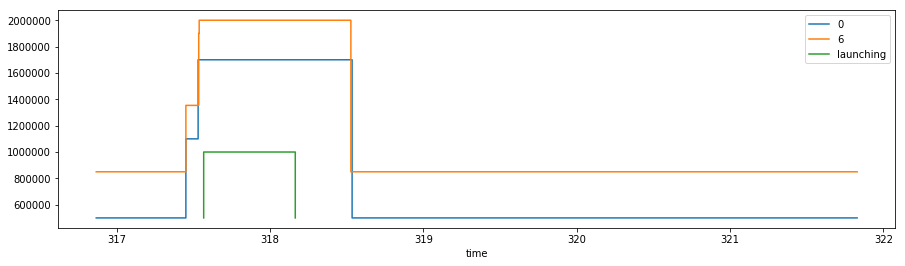

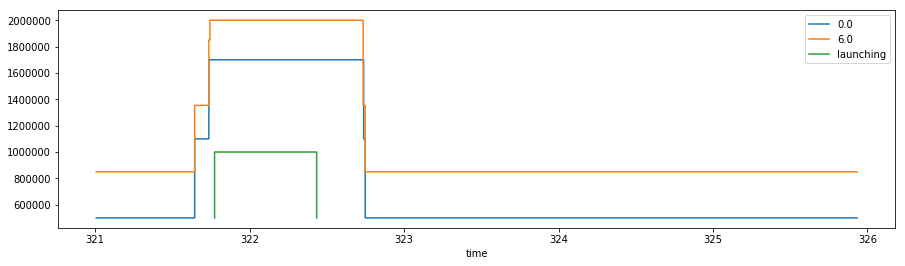

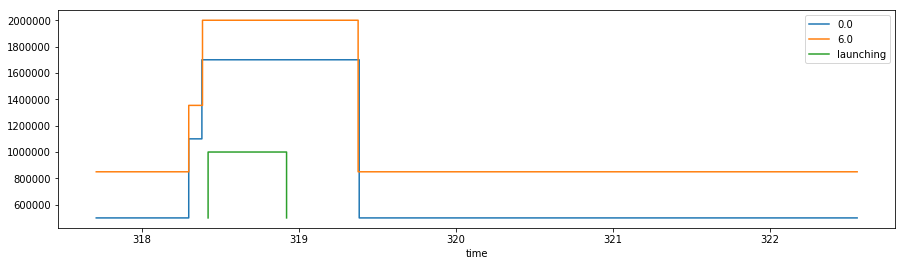

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

0EBF5_0FBF5TA2_QOS_200117_200117_181416_note
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']


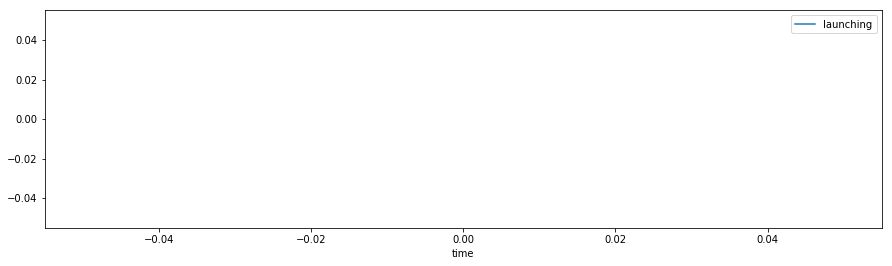

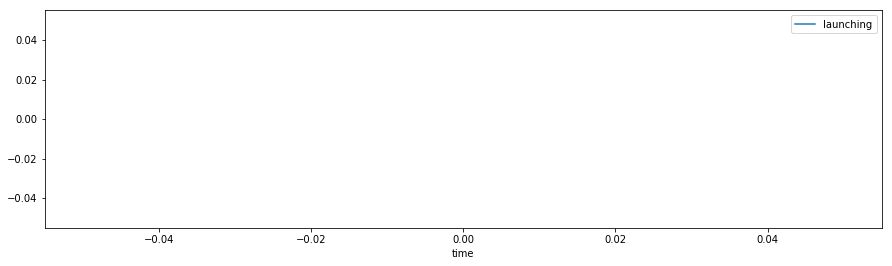

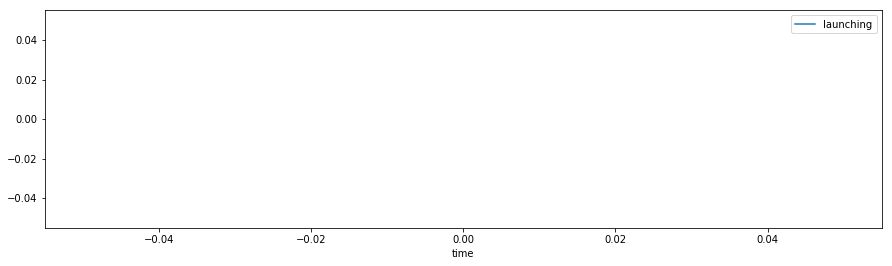

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

Naver_0CAH5_Naver_2019_08_23_07_30_01_1


KeyError: 'end_time'

Naver_9IBA5_Naver_2019_08_23_07_28_19_4


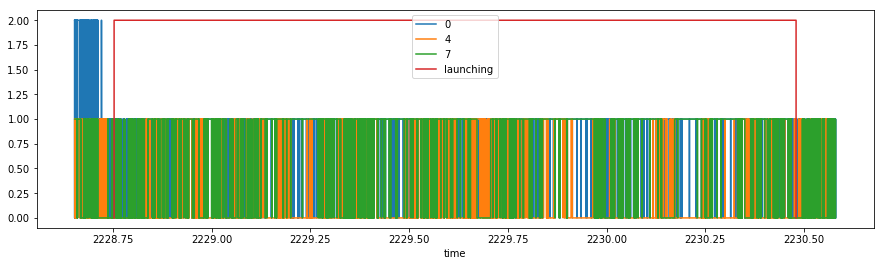

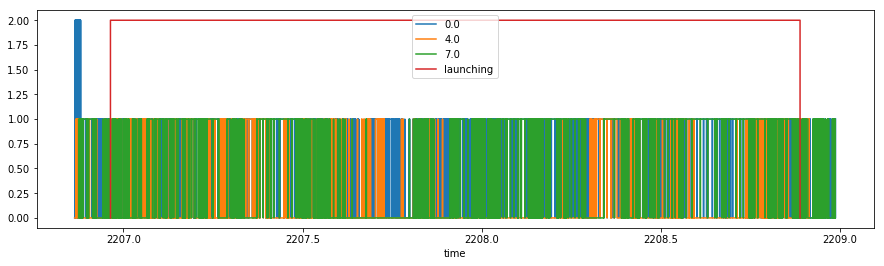

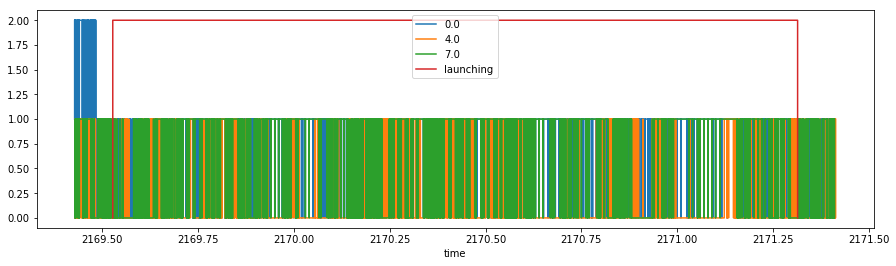

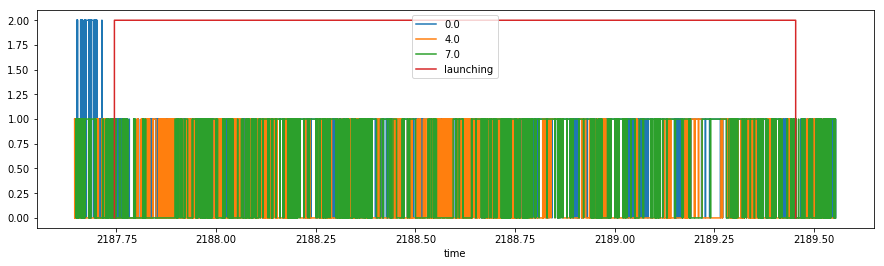

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
Naver_0CAH5_Naver_2019_08_23_07_30_01_1,lock_contention,0,19.839,0.000,6.214,19.609,7.703,6.053,0
Naver_9IBA5_Naver_2019_08_23_07_28_19_4,lock_contention,0,11.312,10.164,20.236,39.391,12.757,0.316,0
DIFF,lock_contention,0,8.527,-10.164,-14.022,-19.782,-5.054,5.737,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'Naver_0CAH5_Naver_2019_08_23_07_30_01_1'

,blocking,context,duration,effection,owner,pid,time,type
17,boolean com.android.server.wm.WindowManagerSe...,monitor contention with owner android.anim (14...,11.670,O,android.anim (1478) at int com.android.server....,6055,2400.600371,B
22,void com.android.server.am.ActivityMetricsLog...,monitor contention with owner Binder:1368_14 (...,6.559,O,Binder:1368_14 (6055) at void com.android.serv...,1368,2400.612578,B
88,void com.android.server.am.ActivityMetricsLog...,monitor contention with owner Binder:1368_20 (...,5.740,O,Binder:1368_20 (13532) at int com.android.serv...,1368,2401.278988,B
77,int com.android.server.pm.PackageManagerServi...,monitor contention with owner Binder:1368_D (3...,5.289,O,Binder:1368_D (3170) at java.util.List com.and...,1368,2401.242198,B
67,java.lang.String com.android.server.am.Activi...,monitor contention with owner Binder:1368_20 (...,4.959,O,Binder:1368_20 (13532) at boolean com.android....,1368,2401.224772,B
116,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1368_20 (...,4.243,O,Binder:1368_20 (13532) at int com.android.serv...,1368,2402.309401,B
89,int com.android.server.am.ActivityManagerServ...,monitor contention with owner Binder:1368_20 (...,4.234,O,Binder:1368_20 (13532) at int com.android.serv...,6055,2401.281687,B
18,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1368_14 (...,3.491,O,Binder:1368_14 (6055) at void com.android.serv...,1368,2400.603653,B
23,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1368_14 (...,3.478,O,Binder:1368_14 (6055) at void com.android.serv...,1368,2400.615659,B
51,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (14...,3.337,O,android.anim (1478) at void com.android.server...,1368,2400.909886,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'Naver_9IBA5_Naver_2019_08_23_07_28_19_4'

,blocking,context,duration,effection,owner,pid,time,type
53,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1589_1F (...,14.989,O,Binder:1589_1F (13917),1614,2228.766673,B
90,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1589_D (3...,10.428,O,Binder:1589_D (3001),25414,2229.285222,B
47,boolean com.android.server.wm.WindowManagerSe...,monitor contention with owner android.anim (16...,9.294,O,android.anim (1680),13917,2228.755135,B
86,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,6.800,O,android.anim (1680),1627,2229.094328,B
77,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,6.454,O,android.anim (1680),13917,2228.801221,B
107,int com.android.server.pm.PackageManagerServi...,monitor contention with owner Binder:1589_16 (...,6.360,O,Binder:1589_16 (4097),3001,2229.342248,B
150,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1589_7 (1...,6.009,O,Binder:1589_7 (1958),1627,2230.327614,B
48,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,6.006,O,android.anim (1680),1627,2228.758519,B
108,void android.app.SharedPreferencesImpl$2.run(...,monitor contention with owner Thread-16 (25418...,3.275,O,Thread-16 (25418),25427,2229.349300,B
115,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1589_D (3...,3.103,O,Binder:1589_D (3001),1958,2229.353106,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'Naver_0CAH5_Naver_2019_08_23_07_30_01_1'

95.11000000065906

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'Naver_9IBA5_Naver_2019_08_23_07_28_19_4'

130.8310000003985

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'Naver_0CAH5_Naver_2019_08_23_07_30_01_1'

,owner
android.anim (1478) at void com.android.server.wm.WindowSurfacePlacer.lambda$new$0(com.android.server.wm.WindowSurfacePlacer)(WindowSurfacePlacer.java:122),5
Binder:1368_14 (6055) at void com.android.server.am.ActivityManagerService.activityPaused(android.os.IBinder)(ActivityManagerService.java:10726),5
Binder:1368_20 (13532) at boolean com.android.server.am.ActivityManagerService.unbindService(android.app.IServiceConnection)(ActivityManagerService.java:25418),4
"Binder:1368_20 (13532) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.Surface, android.graphics.PointF, com.samsung.android.view.ConventionalModeBar$Info)(WindowManagerService.java:2232)",3
ActivityManager (1415) at void com.android.server.am.TaskChangeNotificationController$MainHandler.handleMessage(android.os.Message)(TaskChangeNotificationController.java:152),3
android.anim (1478) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),3
Binder:1368_20 (13532) at android.app.ActivityManager$StackInfo com.android.server.am.ActivityManagerService.getFocusedStackInfo()(ActivityManagerService.java:27419),2
"Binder:1368_14 (6055) at void com.android.server.am.ActivityManagerService.attachApplication(android.app.IApplicationThread, long)(ActivityManagerService.java:10300)",2
"Binder:1368_4 (1892) at void com.android.server.wm.WindowManagerService.statusBarVisibilityChanged(int, int)(WindowManagerService.java:7256)",2
"Binder:1368_14 (6055) at void com.android.server.wm.WindowManagerService.setFocusedApp(android.os.IBinder, boolean)(WindowManagerService.java:3104)",2


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'Naver_9IBA5_Naver_2019_08_23_07_28_19_4'

,owner
Binder:1589_D (3001),21
Binder:1589_1F (13917),15
android.anim (1680),9
Binder:1589_16 (4097),8
Binder:1589_7 (1958),7
ActivityManager (1613),7
android.ui (1614),3
Binder:1589_17 (4098),3
Binder:1589_B (2776),3
main (25350),2


Text(0,0.5,'weight')

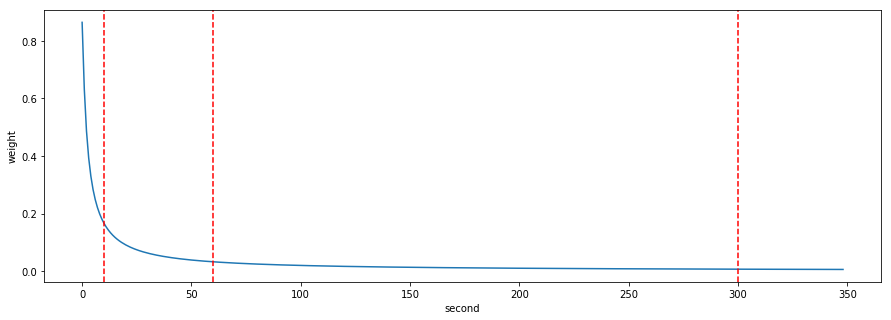

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')